# Apply convolutional neural network to MNIST hand-written digits dataset

In [1]:
# As usual, a bit of setup

import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

def rel_error(x, y):
  """ returns relative error """
  return np.max(np.abs(x - y) / (np.maximum(1e-8, np.abs(x) + np.abs(y))))

In [2]:
# Copyright 2015 Google Inc. All Rights Reserved.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
# ==============================================================================

"""Simple, end-to-end, LeNet-5-like convolutional MNIST model example.

This should achieve a test error of 0.7%. Please keep this model as simple and
linear as possible, it is meant as a tutorial for simple convolutional models.
Run with --self_test on the command line to execute a short self-test.
"""
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import gzip
import os
import sys
import time

import numpy
from six.moves import urllib
from six.moves import xrange  # pylint: disable=redefined-builtin
import tensorflow as tf

SOURCE_URL = 'http://yann.lecun.com/exdb/mnist/'
WORK_DIRECTORY = 'data'
IMAGE_SIZE = 28
NUM_CHANNELS = 1
PIXEL_DEPTH = 255
NUM_LABELS = 10
VALIDATION_SIZE = 5000  # Size of the validation set.
SEED = 66478  # Set to None for random seed.
BATCH_SIZE = 64
NUM_EPOCHS = 10
EVAL_BATCH_SIZE = 64
EVAL_FREQUENCY = 100  # Number of steps between evaluations.


tf.app.flags.DEFINE_boolean("self_test", False, "True if running a self test.")
FLAGS = tf.app.flags.FLAGS

In [3]:
def maybe_download(filename):
  """Download the data from Yann's website, unless it's already here."""
  if not tf.gfile.Exists(WORK_DIRECTORY):
    tf.gfile.MakeDirs(WORK_DIRECTORY)
  filepath = os.path.join(WORK_DIRECTORY, filename)
  if not tf.gfile.Exists(filepath):
    filepath, _ = urllib.request.urlretrieve(SOURCE_URL + filename, filepath)
    with tf.gfile.GFile(filepath) as f:
      size = f.Size()
    print('Successfully downloaded', filename, size, 'bytes.')
  return filepath


def extract_data(filename, num_images):
  """Extract the images into a 4D tensor [image index, y, x, channels].

  Values are rescaled from [0, 255] down to [-0.5, 0.5].
  """
  print('Extracting', filename)
  with gzip.open(filename) as bytestream:
    bytestream.read(16)
    buf = bytestream.read(IMAGE_SIZE * IMAGE_SIZE * num_images)
    data = numpy.frombuffer(buf, dtype=numpy.uint8).astype(numpy.float32)
    data = (data - (PIXEL_DEPTH / 2.0)) / PIXEL_DEPTH
    data = data.reshape(num_images, IMAGE_SIZE, IMAGE_SIZE, 1)
    return data


def extract_labels(filename, num_images):
  """Extract the labels into a vector of int64 label IDs."""
  print('Extracting', filename)
  with gzip.open(filename) as bytestream:
    bytestream.read(8)
    buf = bytestream.read(1 * num_images)
    labels = numpy.frombuffer(buf, dtype=numpy.uint8).astype(numpy.int64)
  return labels


def fake_data(num_images):
  """Generate a fake dataset that matches the dimensions of MNIST."""
  data = numpy.ndarray(
      shape=(num_images, IMAGE_SIZE, IMAGE_SIZE, NUM_CHANNELS),
      dtype=numpy.float32)
  labels = numpy.zeros(shape=(num_images,), dtype=numpy.int64)
  for image in xrange(num_images):
    label = image % 2
    data[image, :, :, 0] = label - 0.5
    labels[image] = label
  return data, labels


def error_rate(predictions, labels):
  """Return the error rate based on dense predictions and sparse labels."""
  return 100.0 - (
      100.0 *
      numpy.sum(numpy.argmax(predictions, 1) == labels) /
      predictions.shape[0])

def load_test_data():
    print('Running self-test.')
    train_data, train_labels = fake_data(256)
    validation_data, validation_labels = fake_data(EVAL_BATCH_SIZE)
    test_data, test_labels = fake_data(EVAL_BATCH_SIZE)
    return {
        'X_train': train_data,
        'y_train': train_labels,
        'X_test': test_data,
        'y_test': test_labels,
        'X_val': validation_data,
        'y_val': validation_labels,
    }
    
def load_data():
    # Get the data.
    train_data_filename = maybe_download('train-images-idx3-ubyte.gz')
    train_labels_filename = maybe_download('train-labels-idx1-ubyte.gz')
    test_data_filename = maybe_download('t10k-images-idx3-ubyte.gz')
    test_labels_filename = maybe_download('t10k-labels-idx1-ubyte.gz')

    # Extract it into numpy arrays.
    train_data = extract_data(train_data_filename, 60000)
    train_labels = extract_labels(train_labels_filename, 60000)
    test_data = extract_data(test_data_filename, 10000)
    test_labels = extract_labels(test_labels_filename, 10000)
    # Generate a validation set.
    validation_data = train_data[:VALIDATION_SIZE, ...]
    validation_labels = train_labels[:VALIDATION_SIZE]
    train_data = train_data[VALIDATION_SIZE:, ...]
    train_labels = train_labels[VALIDATION_SIZE:]
    data = {
        'X_train': train_data,
        'y_train': train_labels,
        'X_test': test_data,
        'y_test': test_labels,
        'X_val': validation_data,
        'y_val': validation_labels,
    }
    for k, v in sorted(data.items()):
        print('%s: ' % k, v.shape)
    return data


In [4]:
data = load_data()

Extracting data/train-images-idx3-ubyte.gz
Extracting data/train-labels-idx1-ubyte.gz
Extracting data/t10k-images-idx3-ubyte.gz
Extracting data/t10k-labels-idx1-ubyte.gz
X_test:  (10000, 28, 28, 1)
X_train:  (55000, 28, 28, 1)
X_val:  (5000, 28, 28, 1)
y_test:  (10000,)
y_train:  (55000,)
y_val:  (5000,)


# load data and visualization

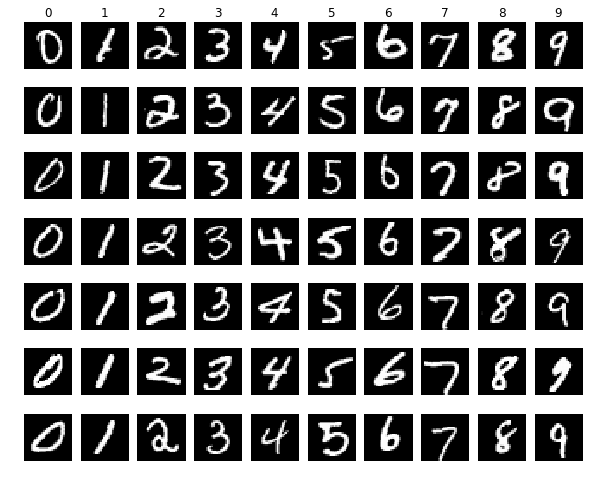

In [5]:
num_epochs = 1
num_epochs = NUM_EPOCHS


train_size = data['y_train'].shape[0]

classes = set(data['y_train'])
num_classes = len(classes)
samples_per_class = 7
for y, cls in enumerate(classes):
    idxs = np.flatnonzero(data['y_train'] == y)
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(data['X_train'][idx].reshape((28, 28)))
        plt.axis('off')
        if i == 0:
            plt.title(cls)
plt.show()

# data node, parameter initialization and the model

In [6]:
# This is where training samples and labels are fed to the graph.
# These placeholder nodes will be fed a batch of training data at each
# training step using the {feed_dict} argument to the Run() call below.
train_data_node = tf.placeholder(
    tf.float32,
    shape=(BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, NUM_CHANNELS))
train_labels_node = tf.placeholder(tf.int64, shape=(BATCH_SIZE,))
eval_data_node = tf.placeholder(
    tf.float32,
    shape=(EVAL_BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, NUM_CHANNELS))

# The variables below hold all the trainable weights. They are passed an
# initial value which will be assigned when we call:
# {tf.initialize_all_variables().run()}
conv1_weights = tf.Variable(
    tf.truncated_normal([5, 5, NUM_CHANNELS, 32],  # 5x5 filter, depth 32.
                        stddev=0.1,
                        seed=SEED))
conv1_biases = tf.Variable(tf.zeros([32]))
conv2_weights = tf.Variable(
    tf.truncated_normal([5, 5, 32, 64],
                        stddev=0.1,
                        seed=SEED))
conv2_biases = tf.Variable(tf.constant(0.1, shape=[64]))
fc1_weights = tf.Variable(  # fully connected, depth 512.
    tf.truncated_normal(
        [IMAGE_SIZE // 4 * IMAGE_SIZE // 4 * 64, 512],
        stddev=0.1,
        seed=SEED))
fc1_biases = tf.Variable(tf.constant(0.1, shape=[512]))
fc2_weights = tf.Variable(
    tf.truncated_normal([512, NUM_LABELS],
                        stddev=0.1,
                        seed=SEED))
fc2_biases = tf.Variable(tf.constant(0.1, shape=[NUM_LABELS]))

# We will replicate the model structure for the training subgraph, as well
# as the evaluation subgraphs, while sharing the trainable parameters.
def model(data, train=False):
    """The Model definition."""
    # 2D convolution, with 'SAME' padding (i.e. the output feature map has
    # the same size as the input). Note that {strides} is a 4D array whose
    # shape matches the data layout: [image index, y, x, depth].
    conv = tf.nn.conv2d(data,
                        conv1_weights,
                        strides=[1, 1, 1, 1],
                        padding='SAME')
    # Bias and rectified linear non-linearity.
    relu = tf.nn.relu(tf.nn.bias_add(conv, conv1_biases))
    # Max pooling. The kernel size spec {ksize} also follows the layout of
    # the data. Here we have a pooling window of 2, and a stride of 2.
    pool = tf.nn.max_pool(relu,
                          ksize=[1, 2, 2, 1],
                          strides=[1, 2, 2, 1],
                          padding='SAME')
    conv = tf.nn.conv2d(pool,
                        conv2_weights,
                        strides=[1, 1, 1, 1],
                        padding='SAME')
    relu = tf.nn.relu(tf.nn.bias_add(conv, conv2_biases))
    pool = tf.nn.max_pool(relu,
                          ksize=[1, 2, 2, 1],
                          strides=[1, 2, 2, 1],
                          padding='SAME')
    # Reshape the feature map cuboid into a 2D matrix to feed it to the
    # fully connected layers.
    pool_shape = pool.get_shape().as_list()
    reshape = tf.reshape(
        pool,
        [pool_shape[0], pool_shape[1] * pool_shape[2] * pool_shape[3]])
    # Fully connected layer. Note that the '+' operation automatically
    # broadcasts the biases.
    hidden = tf.nn.relu(tf.matmul(reshape, fc1_weights) + fc1_biases)
    # Add a 50% dropout during training only. Dropout also scales
    # activations such that no rescaling is needed at evaluation time.
    if train:
        hidden = tf.nn.dropout(hidden, 0.5, seed=SEED)
    return tf.matmul(hidden, fc2_weights) + fc2_biases

# Build the computation graph

In [7]:
# Training computation: logits + cross-entropy loss.
logits = model(train_data_node, True)
loss = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(
    logits, train_labels_node))

# L2 regularization for the fully connected parameters.
regularizers = (tf.nn.l2_loss(fc1_weights) + tf.nn.l2_loss(fc1_biases) +
                tf.nn.l2_loss(fc2_weights) + tf.nn.l2_loss(fc2_biases))
# Add the regularization term to the loss.
loss += 5e-4 * regularizers

# Optimizer: set up a variable that's incremented once per batch and
# controls the learning rate decay.
batch = tf.Variable(0)
# Decay once per epoch, using an exponential schedule starting at 0.01.
learning_rate = tf.train.exponential_decay(
    0.01,                # Base learning rate.
    batch * BATCH_SIZE,  # Current index into the dataset.
    train_size,          # Decay step.
    0.95,                # Decay rate.
    staircase=True)
# Use simple momentum for the optimization.
optimizer = tf.train.MomentumOptimizer(learning_rate,
                                       0.9).minimize(loss,
                                                     global_step=batch)

# Predictions for the current training minibatch.
train_prediction = tf.nn.softmax(logits)

# Predictions for the test and validation, which we'll compute less often.
eval_prediction = tf.nn.softmax(model(eval_data_node))

# Small utility function to evaluate a dataset by feeding batches of data to
# {eval_data} and pulling the results from {eval_predictions}.
# Saves memory and enables this to run on smaller GPUs.
def eval_in_batches(data, sess):
    """Get all predictions for a dataset by running it in small batches."""
    size = data.shape[0]
    if size < EVAL_BATCH_SIZE:
        raise ValueError(
            "batch size for evals larger than dataset: %d" %
            size)
    predictions = numpy.ndarray(
        shape=(
            size,
            NUM_LABELS),
        dtype=numpy.float32)
    for begin in xrange(0, size, EVAL_BATCH_SIZE):
        end = begin + EVAL_BATCH_SIZE
        if end <= size:
            predictions[begin:end, :] = sess.run(
                eval_prediction,
                feed_dict={eval_data_node: data[begin:end, ...]})
        else:
            batch_predictions = sess.run(
                eval_prediction,
                feed_dict={eval_data_node: data[-EVAL_BATCH_SIZE:, ...]})
            predictions[begin:, :] = batch_predictions[begin - size:, :]
    return predictions

# run the computation graph

In [8]:
def train(data, sess):
    train_data = data['X_train']
    train_labels = data['y_train']
    validation_data = data['X_val']
    validation_labels = data['y_val']
    test_data = data['X_test']
    test_labels = data['y_test']
    # Create a local session to run the training.
    start_time = time.time()
    print('Initialized!')
    # Loop through training steps.
    for step in xrange(int(num_epochs * train_size) // BATCH_SIZE):
        # Compute the offset of the current minibatch in the data.
        # Note that we could use better randomization across epochs.
        offset = (step * BATCH_SIZE) % (train_size - BATCH_SIZE)
        batch_data = train_data[offset:(offset + BATCH_SIZE), ...]
        batch_labels = train_labels[offset:(offset + BATCH_SIZE)]
        # This dictionary maps the batch data (as a numpy array) to the
        # node in the graph it should be fed to.
        feed_dict = {train_data_node: batch_data,
                     train_labels_node: batch_labels}
        # Run the graph and fetch some of the nodes.
        _, l, lr, predictions = sess.run(
            [optimizer, loss, learning_rate, train_prediction],
            feed_dict=feed_dict)
        if step % EVAL_FREQUENCY == 0:
            elapsed_time = time.time() - start_time
            start_time = time.time()
            print('Step %d (epoch %.2f), %.1f ms' %
                  (step, float(step) * BATCH_SIZE / train_size,
                   1000 * elapsed_time / EVAL_FREQUENCY))
            print('Minibatch loss: %.3f, learning rate: %.6f' % (l, lr))
            print(
                'Minibatch error: %.1f%%' %
                error_rate(
                    predictions,
                    batch_labels))
            print('Validation error: %.1f%%' % error_rate(
                eval_in_batches(validation_data, sess), validation_labels))
            sys.stdout.flush()
    # Finally print the result!
    test_labels_predict = eval_in_batches(test_data, sess)
    test_error = error_rate(test_labels_predict, test_labels)
    print('Test error: %.1f%%' % test_error)
    if FLAGS.self_test:
        print('test_error', test_error)
        assert test_error == 0.0, 'expected 0.0 test_error, got %.2f' % (
            test_error,)

In [9]:
sess = tf.Session()
# Run all the initializers to prepare the trainable parameters.
tf.initialize_all_variables().run(session=sess)
train(data, sess)

Initialized!
Step 0 (epoch 0.00), 1.8 ms
Minibatch loss: 12.054, learning rate: 0.010000
Minibatch error: 90.6%
Validation error: 84.6%
Step 100 (epoch 0.12), 208.7 ms
Minibatch loss: 3.269, learning rate: 0.010000
Minibatch error: 6.2%
Validation error: 6.9%
Step 200 (epoch 0.23), 223.0 ms
Minibatch loss: 3.474, learning rate: 0.010000
Minibatch error: 12.5%
Validation error: 3.6%
Step 300 (epoch 0.35), 218.4 ms
Minibatch loss: 3.215, learning rate: 0.010000
Minibatch error: 7.8%
Validation error: 3.4%
Step 400 (epoch 0.47), 202.0 ms
Minibatch loss: 3.224, learning rate: 0.010000
Minibatch error: 6.2%
Validation error: 2.8%
Step 500 (epoch 0.58), 202.1 ms
Minibatch loss: 3.303, learning rate: 0.010000
Minibatch error: 7.8%
Validation error: 2.6%
Step 600 (epoch 0.70), 208.0 ms
Minibatch loss: 3.212, learning rate: 0.010000
Minibatch error: 6.2%
Validation error: 2.7%
Step 700 (epoch 0.81), 207.0 ms
Minibatch loss: 3.008, learning rate: 0.010000
Minibatch error: 3.1%
Validation error: 

In [10]:
saver = tf.train.Saver()
saver.save(sess, 'mnist-sess')

'mnist-sess'

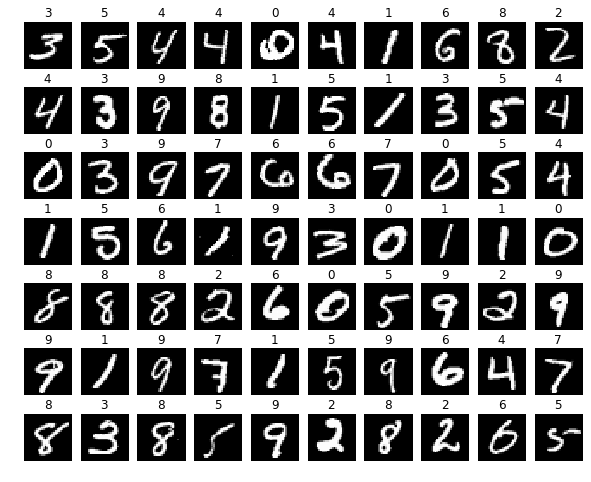

In [11]:
test_sample_idxs = np.random.choice(data['X_test'].shape[0], samples_per_class * num_classes)
test_sample_images = data['X_test'][test_sample_idxs, ...]
test_sample_predict = eval_in_batches(test_sample_images, sess)
for i, sample_predict in enumerate(test_sample_idxs):
    plt_idx = i + 1
    plt.subplot(samples_per_class, num_classes, plt_idx)
    plt.imshow(test_sample_images[i].reshape((28, 28)))
    plt.axis('off')
    plt.title(np.argmax(test_sample_predict[i]))
plt.show()

In [12]:
# load dataset from kaggle for education purpose, not competition
import pandas as pd

IMAGE_TO_DISPLAY = 8
# read training data from CSV file 
train_data_kaggle = pd.read_csv('~/Documents/mine/data/mnist/train.csv')
test_data_kaggle = pd.read_csv('~/Documents/mine/data/mnist/test.csv')

print('data({0[0]},{0[1]})'.format(train_data_kaggle.shape))
print (train_data_kaggle.head())

data(42000,785)
   label  pixel0  pixel1  pixel2  pixel3  pixel4  pixel5  pixel6  pixel7  \
0      1       0       0       0       0       0       0       0       0   
1      0       0       0       0       0       0       0       0       0   
2      1       0       0       0       0       0       0       0       0   
3      4       0       0       0       0       0       0       0       0   
4      0       0       0       0       0       0       0       0       0   

   pixel8    ...     pixel774  pixel775  pixel776  pixel777  pixel778  \
0       0    ...            0         0         0         0         0   
1       0    ...            0         0         0         0         0   
2       0    ...            0         0         0         0         0   
3       0    ...            0         0         0         0         0   
4       0    ...            0         0         0         0         0   

   pixel779  pixel780  pixel781  pixel782  pixel783  
0         0         0         0   

# preprocess data

In [13]:
images = train_data_kaggle.iloc[:,1:].values
images = images.astype(np.float).reshape(
    images.shape[0], IMAGE_SIZE, IMAGE_SIZE, NUM_CHANNELS)

# convert from [0:255] => [0.0:1.0]
images = (images - (PIXEL_DEPTH / 2.0)) / PIXEL_DEPTH

print('images({0})'.format(images.shape))

test_images = test_data_kaggle.values.reshape(
    -1, IMAGE_SIZE, IMAGE_SIZE, NUM_CHANNELS)
test_images = test_images.astype(np.float)

# convert from [0:255] => [0.0:1.0]
test_images = (test_images - (PIXEL_DEPTH / 2.0)) / PIXEL_DEPTH
print('images({0[0]},{0[1]},{0[2]},{0[3]})'.format(test_images.shape))

images((42000, 28, 28, 1))
images(28000,28,28,1)


In [14]:
image_size = images.shape[1]
print ('image_size => {0}'.format(image_size))

# in this case all images are square
image_width = image_height = np.ceil(np.sqrt(image_size)).astype(np.uint8)

print ('image_width => {0}\nimage_height => {1}'.format(image_width,image_height))

image_size => 28
image_width => 6
image_height => 6


In [15]:
labels_flat = train_data_kaggle[[0]].values.ravel()

print('labels_flat({0})'.format(len(labels_flat)))
print ('labels_flat[{0}] => {1}'.format(IMAGE_TO_DISPLAY,labels_flat[IMAGE_TO_DISPLAY]))

labels_flat(42000)
labels_flat[8] => 5


For most classification problems "one-hot vectors" are used. A one-hot vector is a vector that contains a single element equal to $1$ and the rest of the elements equal to $0$. In this case, the $n$th digit is represented as a zero vector with $1$ in the $n$th position.
However, tensorflow supports dense labels, so we don't need to convert it


In [16]:
# convert class labels from scalars to one-hot vectors
# 0 => [1 0 0 0 0 0 0 0 0 0]
# 1 => [0 1 0 0 0 0 0 0 0 0]
# ...
# 9 => [0 0 0 0 0 0 0 0 0 1]
def dense_to_one_hot(labels_dense, num_classes):
    num_labels = labels_dense.shape[0]
    index_offset = np.arange(num_labels) * num_classes
    labels_one_hot = np.zeros((num_labels, num_classes))
    labels_one_hot.flat[index_offset + labels_dense.ravel()] = 1
    return labels_one_hot

labels_count = np.unique(labels_flat).shape[0]
# labels = dense_to_one_hot(labels_flat, labels_count)
labels = labels_flat
# labels = labels.astype(np.uint8)

print('labels({0})'.format(labels.shape))
print ('labels[{0}] => {1}'.format(IMAGE_TO_DISPLAY,labels[IMAGE_TO_DISPLAY]))

labels((42000,))
labels[8] => 5


In [17]:
# split data into training & validation
validation_images = images[:VALIDATION_SIZE]
validation_labels = labels[:VALIDATION_SIZE]

train_images = images[VALIDATION_SIZE:]
train_labels = labels[VALIDATION_SIZE:]

print('train_images({0[0]},{0[1]})'.format(train_images.shape))
print('validation_images({0[0]},{0[1]})'.format(validation_images.shape))

train_images(37000,28)
validation_images(5000,28)


In [18]:
labels_predict_kaggle = eval_in_batches(train_images, sess)

In [19]:
print('trains error: %.1f%%' % error_rate(labels_predict_kaggle, train_labels))

trains error: 0.3%


# predict and write predictions to file

In [20]:
labels_predict_kaggle_test = eval_in_batches(test_images, sess)

In [21]:
with open('submit.csv', 'w') as f:
    f.write('ImageId,Label\n')
    for i in range(labels_predict_kaggle_test.shape[0]):
        f.write('%d,%d\n' % (i+1, np.argmax(labels_predict_kaggle_test[i])))